### Stock Prediction - Using Neural Networks - TensorFlow

<b>Notebook Author:</b> Nirupam Purushothama

Tutorial based on the following [source](https://medium.com/mlreview/a-simple-deep-learning-model-for-stock-price-prediction-using-tensorflow-30505541d877); [code](https://github.com/sebastianheinz/stockprediction/blob/master/02_code/stockprediction.py)

The notebook covers the following topics:
1. Neural networks
2. Brief comparison between Keras, TensorFlow and PyTorch
3. Implements one deep neural network for predicting S&P index 

#### 1. Initial - The usual

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot

Load data

In [2]:
# Prepare data
data = pd.read_csv("../../data/data_stocks.csv")

# Drop the date variable
data = data.drop(['DATE'],1)

# Get the dimensions
n = data.shape[0]
p = data.shape[1]

File was apparently cleaned and hence there is no need to adjust for any missing values etc.
Just visualize the SP500 data 

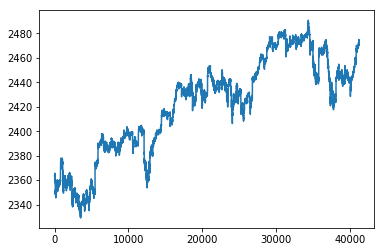

In [3]:
# Check the timeseries plot of the data
pyplot.plot(data['SP500'])

In [4]:
# Change the data to numpy array
data = data.values

#### 2. Divide the data into training and testing datasets

In [5]:
# Training and test data
train_start = 0
train_end = int(np.floor(0.2*n))

test_start = train_end
test_end = int(np.floor(0.3*n))

data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

### Detour 1...

#### Deep Neural Networks
AnalyticsVidhya has decent article on the same and it is shared [here](https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/). Most of the content below is from that article.

0. What does a deep neural net look like?
   <img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/10/13170054/nn.png" alt="Activation function" height="100" width="500"/>

1. Design of a single neuron in the neural network
   <img src="https://dzone.com/storage/temp/5939898-artificialneuron.jpg" alt="Activation function" height="100" width="400"/>

2. Each neuron has the following:
   1. Weight
   2. Bias
   3. Activation Function
   
   Neurons do a linear transformation on the input by the weights and biases. The non linear transformation is done by the activation function. i.e. without the activation function, the weights and bias would just do a linear transformation of input.  A neural network without an activation function would just be a linear regression model. Activation function is what allows the neural network to learn.


3. Forward propagation and backward propagation (of information)

   Forward movement of information (from input to output) known as the forward propagation. But what if the output generated is far away (i.e. large deviation) from the expected value? In a neural network, we would update the weights and biases of the neurons on the basis of the error. This process is known as back-propagation. Once the entire data has gone through this process, the final weights and biases are used for predictions.
   

4. Activation function
   <img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/10/17123344/act.png" alt="Activation function" height="100" width="400"/>
   The activation function is the non linear transformation that we do over the input signal. This transformed output is then sen to the next layer of neurons as input. Activation functions make the back-propagation possible since the gradients are supplied along with the error to update the weights and biases
   
   
5. Popular types of activation functions

   [AnalyticsVidhya article - Has graphs](https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/)

   [Fullset of activation functions - Wikipedia](https://en.wikipedia.org/wiki/Activation_function)
   
   1. <b> Binary step-function  </b>
   
   This is a threshold based classifier i.e. it decides whether or not the neuron should be activated. If the value Y is above a given threshold value then activate the neuron else leave it deactivated. Useful for binary classification problems. The article above has an error where it calls the gradient of this step-function as zero. It is incorrect as the derivative of the step function is an impulse (dirac delta function). But I think the point the article makes is that the gradient is not so useful when back-propagated.
   
   2. <b>Linear function</b>
   
   Function can be simply be described as f(x)=ax. Here the activation is proportional to input i.e. input x, will be transformed to ax. This can be applied to various neurons and multiple neurons can be activated at the same time. Now, when we have multiple classes, we can choose the one which has the maximum value. But the derivate of this function is constant (a) and hence this gradient does not aid in back-propagation of information. Ultimately how-many ever linear transformations we make, the result is a linear transform and hence is useful when we need to interpret the results (just like linear regression).
   
   3. <b>Sigmoid</b>
   
   f(x)=1/(1+e^-x. It is a smooth function and is continuously differentiable. Output is going to be non-linear. As per the article, the goodness of using a sigmoid is that, the derivative is a normal curve with high values between -3 and +3. This means that in this range small changes in x would also bring about large changes in the value of Y. So the function essentially tries to push the Y values towards the extremes. This is a very desirable quality when we’re trying to classify the values to a particular class. Gradient is dependent on x and hence is useful during back propagation. Problems associated with it is that the values only range from 0 to 1. This means that the sigmoid function is not symmetric around the origin and the values received are all positive. So not all times would we desire the values going to the next neuron to be all of the same sign. This can be addressed by scaling the sigmoid function. That’s exactly what happens in the tanh function.
      
   4. <b>Tanh</b>
   
   The tanh function is very similar to the sigmoid function. It is actually just a scaled version of the sigmoid function. tanh(x)=2sigmoid(2x)-1. Tanh works similar to the sigmoid function but is symmetric over the origin. it ranges from -1 to 1. All other properties are the same as that of the sigmoid function. It is continuous and differentiable at all points. The function as you can see is non linear so we can easily backpropagate the errors. The gradient of the tanh function is steeper as compared to the sigmoid function. Our choice of using sigmoid or tanh would basically depend on the requirement of gradient in the problem statement. But similar to the sigmoid function we still have the vanishing gradient problem (read below). The graph of the tanh function is flat and the gradients are very low.
   
   5. <b> ReLU </b>
   
   The ReLU function is the Rectified linear unit. It is the most widely used activation function. It is defined as f(x)=max(0,x). ReLU is the most widely used activation function while designing networks today. First things first, the ReLU function is non linear, which means we can easily backpropagate the errors and have multiple layers of neurons being activated by the ReLU function. The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time. i.e. if the input is negative it will convert it to zero and the neuron does not get activated. This means that at a time only a few neurons are activated making the network sparse making it efficient and easy for computation. But ReLU also has gradients moving towards zero. i.e. on the negative side of the graph, the gradient is zero, which means for activations in that region, the gradient is zero and the weights are not updated during back propagation. This can create dead neurons which never get activated.
   
   6. <b> Leaky ReLU </b>
   
   f(x)= {ax when x<0; = x when x>=0} And a is a very small number. The main advantage of replacing the horizontal line is to remove the zero gradient. So in this case the gradient of the left side of the graph is non zero and so we would no longer encounter dead neurons in that region. 
   
   7. <b> Parameterized ReLU </b>
   
   Same as above. i.e. f(x)= {ax when x<0; = x when x>=0}. But 'a' is also a trainable paramter in this model. The network also learns the value of 'a' for faster and more optimum convergence. The parametrised ReLU function is used when the leaky ReLU function still fails to solve the problem of dead neurons and the relevant information is not successfully passed to the next layer.
   
   8. <b> Softmax </b>
   
   The softmax function is also a type of sigmoid function but is handy when we are trying to handle classification problems. Sigmoid can only handle two classes (i.e. binary classification). But in here, softmax gives the probability of which class the input might belong to. 
   
   <img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/10/17014509/softmax.png" alt="softmax" height="100" width="250"/>
   
   For example: if we have the outputs as [1.2 , 0.9 , 0.75], then after applying softmax we would get the following: [0.42 ,  0.31, 0.27]. So now we can use these as probabilities for the value to be in each class. <b>The softmax function is ideally used in the output layer of the classifier where we are actually trying to attain the probabilities to define the class of each input.</b>
  
  
6. Choice of Activation Function

   According to the article, the following is the logic / heuristics to know which activation function should be used in which situation. They call it rule-of-thumb.

    1. Sigmoid functions and their combinations generally work better in the case of classifiers
    2. Sigmoids and tanh functions are sometimes avoided due to the vanishing gradient problem
    3. ReLU function is a general activation function and is used in most cases these days
    4. If we encounter a case of dead neurons in our networks the leaky ReLU function is the best choice
    5. Always keep in mind that ReLU function should only be used in the hidden layers
    6. As a rule of thumb, you can begin with using ReLU function and then move over to other activation functions in case ReLU doesn’t provide with optimum results
    

7. Vanishing Gradient problem - [In Detail](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)

   The vanishing gradient problem is a difficulty found in training artificial neural networks with gradient-based learning methods and backpropagation. In such methods, each of the neural network's weights receives an update proportional to the partial derivative of the error function with respect to the current weight in each iteration of training. The problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. In the worst case, this may completely stop the neural network from further training. As one example of the problem cause, traditional activation functions such as the hyperbolic tangent function have gradients in the range (0, 1), and backpropagation computes gradients by the chain rule. This has the effect of multiplying n of these small numbers to compute gradients of the "front" layers in an n-layer network, meaning that the gradient (error signal) decreases exponentially with n while the front layers train very slowly. 

### ...Back to the problem
#### 3. Scaling data

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Scale data

scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

# Build X and y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]

Take a note of how scaling is being applied separately to training and testing data. The article explains that this is to avoid bias (especially with time series data)

### Detour 2...
#### TensorFlow [And briefly about Keras and PyTorch]

TensorFlow operates on a graph representation of the underlying computational task. This approach allows the user to specify mathematical operations as elements in a graph of data, variables and operators. Since neural networks are actually graphs of data and mathematical operations, TensorFlow is a good fit for neural networks and deep learning.

Briefly about [Keras](https://medium.com/implodinggradients/tensorflow-or-keras-which-one-should-i-learn-5dd7fa3f9ca0). Keras is nothing but an abstraction of TensorFlow which allows people to build neural-nets faster. So, if you are thinking Keras/TensorFlow then both are the same, and if you want simplicity and speed then use Keras.

Briefly about [PyTorch](https://deepsense.ai/keras-or-pytorch/). I am yet to use PyTorch but in TensorFlow you define a static model and then train it, whereas PyTorch allows you to define dynamic models. TensorFlow is backed by Google and PyTorch is backed by Facebook. And PyTorch provides better debugging capabilities over TensorFlow and hence is gaining some traction (apparently). So, make your choice. 

I will add one more notebook on Keras and PyTorch shortly. But in the meanwhile lets proceed with TensorFlow in this notebook. Meanwhile this [article](https://www.edureka.co/blog/keras-vs-tensorflow-vs-pytorch/) neatly compares and contrasts all the three frameworks. Keras is the most popular followed by TensorFlow followed by PyTorch which is a distant third. So, for faster prototyping Keras is the most popular.

This [link](https://medium.com/mlreview/a-simple-deep-learning-model-for-stock-price-prediction-using-tensorflow-30505541d877) has a very small and simple example on TensorFlow. Just have a look at it for a quick understanding of how TensorFlow works.
<img src="https://cdn-images-1.medium.com/max/1000/1*aCqfu5QVufgPuJNWg4Vn7g.png" height="100" width="500"/>

### ...Back to the problem
#### 4. TensorFlow Model

Model details (Taken from the article)

<b>4.1. Placeholders</b>:
We need two placeholders in order to fit our model: X contains the network's inputs (the stock prices of all S&P 500 constituents at time T = t) and Y the network's outputs (the index value of the S&P 500 at time T = t + 1).

In [8]:
# Import TensorFlow
import tensorflow as tf

# As on Jan 2019, TensorFlow requires Python3.6 . So downgrade to Python3.6 if you are using Python3.7

##### Key concepts
1. Session vs. Interactive Session - [Link](https://stackoverflow.com/questions/41791469/whats-the-difference-between-tf-session-and-tf-interactivesession)

In [9]:
# Number of stocks in training data
n_stocks = X_train.shape[1]

# Session
net = tf.InteractiveSession()

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

# The shape of the placeholders correspond to [None, n_stocks] with [None] meaning that the inputs are a 
# 2-dimensional matrix and the outputs are a 1-dimensional vector. It is crucial to understand which input 
# and output dimensions the neural net needs in order to design it properly.

# The None argument indicates that at this point we do not yet know the number of observations that flow 
# through the neural net graph in each batch, so we keep if flexible. We will later define the variable 
# batch_size that controls the number of observations per training batch.

#### 4.2. Model details
<b>Model: </b>The model consists of four hidden layers. The first layer contains 1024 neurons, slightly more than double the size of the inputs. Subsequent hidden layers are always half the size of the previous layer, which means 512, 256 and finally 128 neurons. A reduction of the number of neurons for each subsequent layer compresses the information the network identifies in the previous layers. 
<img src="https://cdn-images-1.medium.com/max/1000/1*SHAol6IyUGn5yoXt7mC4Uw.png" height="100" width="600"/>

<b>Variables: </b>While placeholders are used to store input and target data in the graph, variables are used as flexible containers within the graph that are allowed to change during graph execution. Weights and biases are represented as variables in order to adapt during training. Variables need to be initialized, prior to model training.

<b>Initializers: </b> Initializers are used to initialize the network’s variables before training. Since neural networks are trained using numerical optimization techniques, the starting point of the optimization problem is one the key factors to find good solutions to the underlying problem. There are different initializers available in TensorFlow, each with different initialization approaches. With TensorFlow it is possible to define multiple initialization functions for different variables within the graph. However, in most cases, a unified initialization is sufficient. Useful and important Stackoverflow discussion on Initializers [here](https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize)

In [10]:
# Neurons
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128
n_target = 1

# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Layer 1: Variables for hidden weights and biases
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

# Layer 2: Variables for hidden weights and biases
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

# Layer 3: Variables for hidden weights and biases
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))

# Layer 4: Variables for hidden weights and biases
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output layer: Variables for output weights and biases
W_out = tf.Variable(weight_initializer([n_neurons_4, n_target]))
bias_out = tf.Variable(bias_initializer([n_target]))

#### 4.3. Designing the architecture
We defined the individual parts above. Now connect each of the parts to get the model ready

<b>Activation Function: </b>  Activation functions are important elements of the network architecture since they introduce non-linearity to the system. There are dozens of possible activation functions out there, one of the most common is the rectified linear unit (ReLU) which will also be used in this model.

<b>Optimizer: </b> The optimizer takes care of the necessary computations that are used to adapt the network’s weight and bias variables during training. Those computations invoke the calculation of so called gradients, that indicate the direction in which the weights and biases have to be changed during training in order to minimize the network’s cost function. Here the Adam Optimizer is used, which is one of the current default optimizers in deep learning development. Adam stands for "Adaptive Moment Estimation" and can be considered as a combination between two other popular optimizers AdaGrad and RMSProp.
    
<b>Cost Function: </b> The cost function of the network is used to generate a measure of deviation between the network’s predictions and the actual observed training targets. For regression problems, the mean squared error (MSE) function is commonly used. MSE computes the average squared deviation between predictions and targets. Basically, any differentiable function can be implemented in order to compute a deviation measure between predictions and targets.

In [11]:
# After definition of the required weight and bias variables, the network topology, 
# the architecture of the network, needs to be specified. Hereby, placeholders (data) and 
# variables (weighs and biases) need to be combined into a system of sequential matrix multiplications.

# Hidden layer [Refer to the notes on neural networks above to understand what this means].
# This is very simple. Output = activation_function(X * weights + bias)
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

# Output layer (must be transposed)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

# Cost function (used for feedback)
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer - Invokes the feedback loop to improve the weights and biases (uses gradients)
opt = tf.train.AdamOptimizer().minimize(mse)

#### 4.4. Fitting the network - Training the model
This is done by minibatch training. 

<b> About mini-batch training: </b> During minibatch training random data samples of n = batch_size are drawn from the training data and fed into the network. The training dataset gets divided into n / batch_size batches that are sequentially fed into the network. At this point the placeholders X and Y come into play. They store the input and target data and present them to the network as inputs and targets. A sampled data batch of X flows through the network until it reaches the output layer. There, TensorFlow compares the models predictions against the actual observed targets Y in the current batch. Afterwards, TensorFlow conducts an optimization step and updates the networks parameters, corresponding to the selected learning scheme. After having updated the weights and biases, the next batch is sampled and the process repeats itself. The procedure continues until all batches have been presented to the network. 

<b>Epoch: </b> One full sweep over all batches is called an epoch.

<b>Stopping the training: </b> The training of the network stops once the maximum number of epochs is reached or another stopping criterion defined by the user applies.

In [16]:
%matplotlib

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


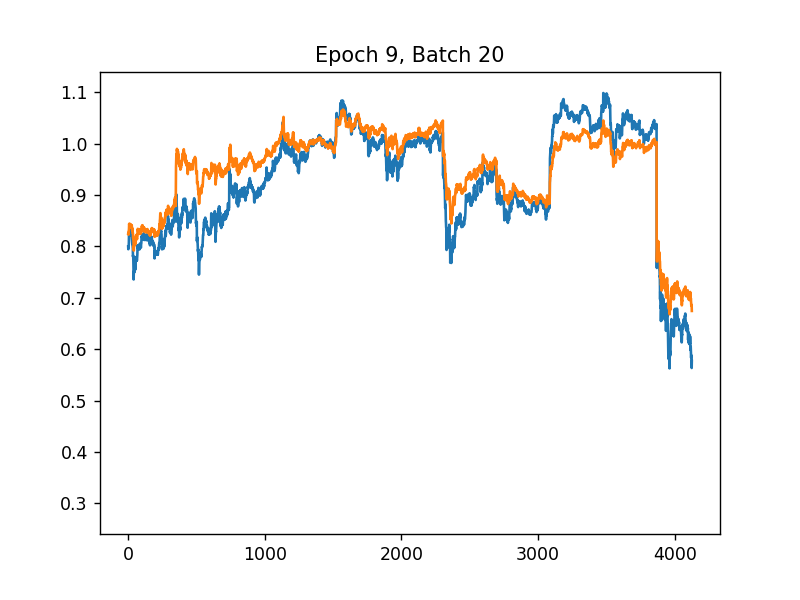

MSE Train:  0.7600792
MSE Test:  0.61009204
MSE Train:  0.009272238
MSE Test:  0.034080584
MSE Train:  0.0028255868
MSE Test:  0.011585714
MSE Train:  0.0019417825
MSE Test:  0.0023277847
MSE Train:  0.0014324633
MSE Test:  0.0063910987
MSE Train:  0.00061688194
MSE Test:  0.0038241656
MSE Train:  0.00052938506
MSE Test:  0.0044425726
MSE Train:  0.0009823309
MSE Test:  0.0026760066
MSE Train:  0.00039634504
MSE Test:  0.0032736238
MSE Train:  0.0003732769
MSE Test:  0.002724748
MSE Train:  0.0005794488
MSE Test:  0.0066184127
MSE Train:  0.0008204225
MSE Test:  0.00609392
MSE Train:  0.00024119415
MSE Test:  0.0031072465
MSE Train:  0.00020049782
MSE Test:  0.0028243011
MSE Train:  0.00019764982
MSE Test:  0.0028071178
MSE Train:  0.00059942156
MSE Test:  0.003900511
MSE Train:  0.00029921564
MSE Test:  0.0037277138
MSE Train:  0.00037312706
MSE Test:  0.003796773
MSE Train:  0.0005537505
MSE Test:  0.0043690577
MSE Train:  0.00015644905
MSE Test:  0.00235171


In [21]:
# Init
net.run(tf.global_variables_initializer())

# Setup plot
pyplot.ion()
fig = pyplot.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test * 0.5)
pyplot.show()

# Fit neural net
batch_size = 256
mse_train = []
mse_test = []

# Run
epochs = 10
for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 20) == 0:
            # MSE train and test
            mse_train.append(net.run(mse, feed_dict={X: X_train, Y: y_train}))
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
            # Prediction
            pred = net.run(out, feed_dict={X: X_test})
            line2.set_ydata(pred)
            pyplot.title('Epoch ' + str(e) + ', Batch ' + str(i))
            file_name = 'img/epoch_' + str(e) + '_batch_' + str(i) + '.jpg'
            pyplot.savefig(file_name)
            pyplot.pause(0.01)

Graph doesn't show properly because of matplotlib related issues in jupyter notebook. You can check the saved files to see how the network evolves over time. 